In [1]:
# Load station master and create the point selection widget
# start with a widget to choose whether we are comparing stations data or just a point location on a map
from ipywidgets import Output
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xarray as xr
import json

import ipywidgets as widgets
from IPython.display import display, HTML
from scipy.spatial import cKDTree as KDTree

# read station master - adjust path if needed
data = pd.read_csv('../utils/allstn2025.csv')
data['name'] = data['name'].astype(str).str.strip()
# ensure lat/lon columns are numeric and present as 'lat' and 'lon'
if 'lat' not in data.columns or 'lon' not in data.columns:
    raise ValueError('Station master must contain lat and lon columns')
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')
data['lon'] = pd.to_numeric(data['lon'], errors='coerce')

# KDTree will be used for nearest-station lookup (lat/lon space).

# point selection dropdown
point_select = widgets.Dropdown(
    options=['Station Comparison', 'Station Comparison from Point', 'Manual Input Point', 'Click on Map Point'],
    value='Station Comparison',
    description='Point Select:',
)

print("Note that only the first two options incorporate station observations. The final two look purely at CaSR data output.")
display(point_select)

Note that only the first two options incorporate station observations. The final two look purely at CaSR data output.


Dropdown(description='Point Select:', options=('Station Comparison', 'Station Comparison from Point', 'Manual …

In [ ]:
# station and coordinate selection widgets with smart autofill and nearest-station lookup
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
# attempt to import ipyleaflet for interactive map clicks; provide safe fallback
try:
    from ipyleaflet import Map, Marker, basemaps
    have_ipyleaflet = True
except Exception:
    Map = None
    Marker = None
    basemaps = None
    have_ipyleaflet = False

# Combobox provides typeahead/autofill behavior
station_combobox = widgets.Combobox(
    placeholder='Type station name...',
    options=list(data['name']),
    ensure_value=False,
    description='Station:',
)

# manual lat/lon inputs (default: geographic middle of Canada)
lat_input = widgets.FloatText(description='Lat', value=62.0)
lon_input = widgets.FloatText(description='Lon', value=-96.0)
find_nearest_btn = widgets.Button(description='Find nearest station')
station_output = widgets.Output()

# create an interactive map widget (or a placeholder message) -- centered on Canada by default
if have_ipyleaflet:
    map_widget = Map(center=(62.0, -96.0), zoom=4, basemap=basemaps.OpenStreetMap.Mapnik)
    map_marker = Marker(location=(62.0, -96.0))
    map_widget.add_layer(map_marker)
else:
    map_widget = widgets.HTML('<b>ipyleaflet not installed — interactive map unavailable.</b>')

def set_selected_from_row(row):
    global selected_station, selected_lat, selected_lon
    selected_station = row['name']
    selected_lat = row['lat']
    selected_lon = row['lon']
    with station_output:
        clear_output()
        station_id = row['wmo'] if 'wmo' in row.index else 'N/A'
        print(f"Selected station: {selected_station} | id: {station_id} | lat: {selected_lat} lon: {selected_lon}")

def on_station_selected(change):
    if change.get('name') == 'value' and change.get('new'):
        val = change.get('new')
        # try exact match first
        rows = data.loc[data['name'] == val]
        if len(rows) == 0:
            # try case-insensitive contains
            rows = data.loc[data['name'].str.contains(str(val), case=False, na=False)]
        if len(rows) > 0:
            set_selected_from_row(rows.iloc[0])

station_combobox.observe(on_station_selected, names='value')

def find_nearest(_):
    # use KDTree to find nearest station in lat/lon space if available
    lat = float(lat_input.value)
    lon = float(lon_input.value)
    # ensure global kdtree exists and is usable
    global kdtree
    try:
        kdtree
    except NameError:
        # attempt to build from data if KDTree class is available
        if 'KDTree' in globals() and KDTree is not None:
            kdtree = KDTree(np.column_stack((data['lat'].values, data['lon'].values)))
        else:
            kdtree = None
    if kdtree is not None:
        dist, idx = kdtree.query([lat, lon], k=1)
        row = data.iloc[int(idx)]
        # update combobox and selected values
        station_combobox.value = row['name']
        set_selected_from_row(row)
    else:
        # KDTree not available; just set selected coords and inform the user
        global selected_lat, selected_lon
        selected_lat = lat
        selected_lon = lon
        with station_output:
            clear_output()
            print(f'Coordinates set to: {selected_lat}, {selected_lon} (nearest-station lookup unavailable)')

find_nearest_btn.on_click(find_nearest)

# map click handler updates lat/lon inputs and (optionally) finds nearest station
def handle_map_interaction(**kwargs):
    if not have_ipyleaflet:
        return
    evtype = kwargs.get('type')
    if evtype != 'click':
        return
    # ipyleaflet may provide 'latlng' or 'coordinates' depending on version
    coords = kwargs.get('latlng') or kwargs.get('coordinates')
    if coords is None:
        return
    # coords may be [lat, lon] or [lon, lat] depending on event; try to normalize
    try:
        # prefer (lat, lon)
        lat, lon = float(coords[0]), float(coords[1])
    except Exception:
        return
    # update marker and inputs
    try:
        map_marker.location = (lat, lon)
    except Exception:
        pass
    lat_input.value = lat
    lon_input.value = lon
    # set selected coords
    global selected_lat, selected_lon
    selected_lat = lat
    selected_lon = lon
    with station_output:
        clear_output()
        print(f'Last clicked coordinates: {lat:.5f}, {lon:.5f}')
    # try nearest-station lookup if possible
    try:
        if 'kdtree' in globals() and kdtree is not None:
            dist, idx = kdtree.query([lat, lon], k=1)
            row = data.iloc[int(idx)]
            station_combobox.value = row['name']
            set_selected_from_row(row)
    except Exception:
        pass

if have_ipyleaflet:
    map_widget.on_interaction(handle_map_interaction)

# react to the top-level point_select to show/hide controls
def on_point_mode(change):
    mode = change['new']
    if mode == 'Station Comparison':
        station_combobox.layout.display = ''
        lat_input.layout.display = 'none'
        lon_input.layout.display = 'none'
        find_nearest_btn.layout.display = 'none'
        map_widget.layout.display = 'none'
    elif mode == 'Station Comparison from Point':
        station_combobox.layout.display = 'none'
        lat_input.layout.display = ''
        lon_input.layout.display = ''
        find_nearest_btn.layout.display = ''
        map_widget.layout.display = 'none'
    elif mode in ['Manual Input', 'Manual Input Point', 'Point Analysis']:
        station_combobox.layout.display = 'none'
        lat_input.layout.display = ''
        lon_input.layout.display = ''
        find_nearest_btn.layout.display = 'none'
        map_widget.layout.display = 'none'
    elif mode == 'Click on Map Point':
        # show the interactive map and hide other controls
        station_combobox.layout.display = 'none'
        lat_input.layout.display = 'none'
        lon_input.layout.display = 'none'
        find_nearest_btn.layout.display = 'none'
        map_widget.layout.display = ''
    else:
        # unknown modes: hide map and show nothing else
        station_combobox.layout.display = 'none'
        lat_input.layout.display = 'none'
        lon_input.layout.display = 'none'
        find_nearest_btn.layout.display = 'none'
        map_widget.layout.display = 'none'
        print("Please make a selection")

# set initial visibility based on current value
point_select.observe(on_point_mode, names='value')
on_point_mode({'new': point_select.value})

display(station_combobox, lat_input, lon_input, find_nearest_btn, map_widget, station_output)

# set the obs value to None if not using station comparison of any sort
if not (point_select.value == 'Station Comparison') or (point_select.value == 'Station Comparison from Point'):
    obs = None  # obs needs a type when not filling


Combobox(value='', description='Station:', layout=Layout(display=''), options=('INDIN TL', 'RAVEN TOWER QD', '…

FloatText(value=62.0, description='Lat', layout=Layout(display='none'))

FloatText(value=-96.0, description='Lon', layout=Layout(display='none'))

Button(description='Find nearest station', layout=Layout(display='none'), style=ButtonStyle())

Map(center=[62.0, -96.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Output()

In [3]:
# input start and end dates for comparison plots
print("ideally this shouldnt be more than a month of so, or itll take a while")

import datetime
start_date = widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=datetime.date(2025, 6, 1)
)

end_date = widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=datetime.date(2025, 6, 1)
)

display(start_date, end_date)

ideally this shouldnt be more than a month of so, or itll take a while


DatePicker(value=datetime.date(2025, 6, 1), description='Start Date', step=1)

DatePicker(value=datetime.date(2025, 6, 1), description='End Date', step=1)

In [4]:
# get both dates in yyyy-mm-dd format
start_date_str = start_date.value.strftime('%Y-%m-%d')
end_date_str = end_date.value.strftime('%Y-%m-%d')
print(f"Selected date range: {start_date_str} to {end_date_str}")

# need to back one day for the CaSR daily files
from datetime import timedelta
start_date_casr = start_date.value - timedelta(days=1)

Selected date range: 2025-06-01 to 2025-06-07


In [5]:
if (point_select.value == 'Station Comparison') or (point_select.value == 'Station Comparison from Point'):
    from etl_station_data import set_query, db_query

    # get the wmo station number from the selected station name
    station_number = data.loc[data['name'] == selected_station, 'wmo'].values[0]
    print(f"Selected station WMO number: {station_number}")

    # if you get a paramiko error here, try installing paramiko 2.12.0 specifically
    # conda install paramiko=2.12.0 --force-reinstall
    query = set_query(start_date_str, end_date_str, station_number)
    print(f"SQL Query: {query}")

    # execute the query on dagan
    db_query(query, csv_output=f"./output/{station_number}_query_output.csv")
else: 
    print("Only looking at CaSR data...")


Selected station WMO number: 71085
SQL Query: SELECT rep_date, ws, wg, wdir FROM can_hly2020s WHERE wmo = '71085' AND rep_date BETWEEN '2025-06-01 00:00:00' AND '2025-06-07 23:00:00' ORDER BY rep_date;
SSH tunnel established
('s-edm-genii', 58766)
Connecting to database cwfis as user fire
Query results saved to ./output/71085_query_output.csv


In [6]:
if (point_select.value == 'Station Comparison') or (point_select.value == 'Station Comparison from Point'):
    obs = pd.read_csv(f"./output/{station_number}_query_output.csv")
    print(obs)
else: 
    print("Nothing to pring here...")

                rep_date    ws  wg   wdir
0    2025-06-01 00:00:00  38.9 NaN  234.0
1    2025-06-01 01:00:00  38.9 NaN  238.0
2    2025-06-01 02:00:00  37.1 NaN  234.0
3    2025-06-01 03:00:00  40.7 NaN  239.0
4    2025-06-01 04:00:00  42.5 NaN  241.0
..                   ...   ...  ..    ...
163  2025-06-07 19:00:00  18.4 NaN   95.0
164  2025-06-07 20:00:00  18.4 NaN   75.0
165  2025-06-07 21:00:00  14.8 NaN   81.0
166  2025-06-07 22:00:00  11.2 NaN   80.0
167  2025-06-07 23:00:00  13.0 NaN   90.0

[168 rows x 4 columns]


In [7]:
from etl_station_data import nearest_points, get_casr_data
neighbours = get_casr_data(start_date_casr, end_date_str, selected_lat, selected_lon)
print(neighbours)


Files to open:  C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_windspeed_m05_d31.h5 C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_winddir_m05_d31.h5
Files to open:  C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_windspeed_m06_d01.h5 C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_winddir_m06_d01.h5
Files to open:  C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_windspeed_m06_d02.h5 C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_winddir_m06_d02.h5
Files to open:  C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_windspeed_m06_d03.h5 C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_winddir_m06_d03.h5
Files to open:  C:\Users\lbuchart\Documents\PROJECTS\wind_climat\climatology\daily\1990-2020_hrly_windspeed_m06_d04.h5 C

In [8]:
# Work with the neighbours Dataframe, interpolate values based on the distance column
# have to loop through each time step and interpolate the values from each neighbour based on distance
datestr = neighbours['t0'].unique()
print(datestr)

spd_interp_df = pd.DataFrame(columns=['date', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'])
dir_interp_df = pd.DataFrame(columns=['date', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'])

for date in datestr:
    dspd = []  # for storing stacked information to keep
    ddir = []
    ddist = [] # store the distance for each timeseries
    print(date)

    # extract the dates values and distance for interpolation
    for index, row in neighbours.iterrows():
        dcheck = list(row["dates"])
        spd_check = list(row['speed'])
        if date in dcheck:
            dspd.append(row["speed"])
            ddir.append(row["direction"])
            ddist.append(row["distance"])

    interp_dir = []
    interp_spd = []
    # carry out the weighted mean on each row (time) place them in 
    wt = np.array( [1/x for x in ddist] )  # create the weights for the points in this day
    ddir = np.array(ddir)
    dspd = np.array(dspd)
    for ii in range(0, np.shape(dspd)[1]):
        interp_dir.append( (ddir[:, ii] * wt).sum() / wt.sum() )
        interp_spd.append( (dspd[:, ii] * wt).sum() / wt.sum() )

    # get the percentiles
    stats = {
        'date': date,
        'p10': np.percentile(interp_spd, 10),
        'p25': np.percentile(interp_spd, 25),
        'p50': np.percentile(interp_spd, 50),
        'p75': np.percentile(interp_spd, 75),
        'p90': np.percentile(interp_spd, 90),
        'p95': np.percentile(interp_spd, 95),
    }
    spd_interp_df.loc[len(spd_interp_df)] = stats   

print(spd_interp_df)     

['1990-05-31T13:00:00' '1990-06-01T13:00:00' '1990-06-02T13:00:00'
 '1990-06-03T13:00:00' '1990-06-04T13:00:00' '1990-06-05T13:00:00'
 '1990-06-06T13:00:00' '1990-06-07T13:00:00']
1990-05-31T13:00:00
1990-06-01T13:00:00
1990-06-02T13:00:00
1990-06-03T13:00:00
1990-06-04T13:00:00
1990-06-05T13:00:00
1990-06-06T13:00:00
1990-06-07T13:00:00
                  date       p10       p25       p50        p75        p90  \
0  1990-05-31T13:00:00  3.956783  5.760199  8.923895  13.170425  18.722037   
1  1990-06-01T13:00:00  4.126257  5.703038  8.530435  12.745386  18.621125   
2  1990-06-02T13:00:00  4.261615  6.318909  9.594873  14.188304  19.111598   
3  1990-06-03T13:00:00  3.642327  5.535415  8.117897  12.669103  17.672906   
4  1990-06-04T13:00:00  3.397383  5.456646  7.612558  12.986704  18.675579   
5  1990-06-05T13:00:00  4.409586  6.135831  9.079384  13.590085  18.309588   
6  1990-06-06T13:00:00  4.023904  6.427127  9.479853  14.910025  20.122807   
7  1990-06-07T13:00:00  4.210930  6.

In [9]:
# stuff for a nicer plot
def _replace_year_safe(ts, year):
    """ Replace the year on a pandas Timestamp """
    if pd.isna(ts):
        return ts
    try:
        return ts.replace(year=year)
    except ValueError:
        # ts is Feb 29 and target year isn't leap -> fallback to Feb 28
        return ts.replace(year=year, month=2, day=28)

def align_series_year(dt_series, target_year):
    """
    Given a Series/Index/array-like of datetimes, return a Series of datetimes
    with each element's year replaced by target_year 
    """
    dt = pd.to_datetime(dt_series)  # preserves NaT
    return dt.map(lambda t: _replace_year_safe(t, int(target_year)))

x = pd.to_datetime(spd_interp_df['date'])

x_shifted = x + pd.Timedelta(hours=11)  # this is essentially the mean of the CaSR daily file
try:
    target_year = start_date.value.year
except Exception:
    target_year = pd.to_datetime(start_date).year


x_aligned = align_series_year(x_shifted, target_year)
# convert to a dataframe to convert to YYYY-MM-DD HH:MM:SS
ddf = pd.DataFrame({'date': x_aligned})
df_aligned = pd.to_datetime(ddf['date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d %H:%M:%S')
x_aligned = list(df_aligned)  # clanky as hell, just how I like it
print(x_aligned)

['2025-06-01 00:00:00', '2025-06-02 00:00:00', '2025-06-03 00:00:00', '2025-06-04 00:00:00', '2025-06-05 00:00:00', '2025-06-06 00:00:00', '2025-06-07 00:00:00', '2025-06-08 00:00:00']


['2025-06-01 00:00:00', '2025-06-02 00:00:00', '2025-06-03 00:00:00', '2025-06-04 00:00:00', '2025-06-05 00:00:00', '2025-06-06 00:00:00', '2025-06-07 00:00:00', '2025-06-08 00:00:00'] 0      2025-06-01 00:00:00
1      2025-06-01 01:00:00
2      2025-06-01 02:00:00
3      2025-06-01 03:00:00
4      2025-06-01 04:00:00
              ...         
163    2025-06-07 19:00:00
164    2025-06-07 20:00:00
165    2025-06-07 21:00:00
166    2025-06-07 22:00:00
167    2025-06-07 23:00:00
Name: rep_date, Length: 168, dtype: object


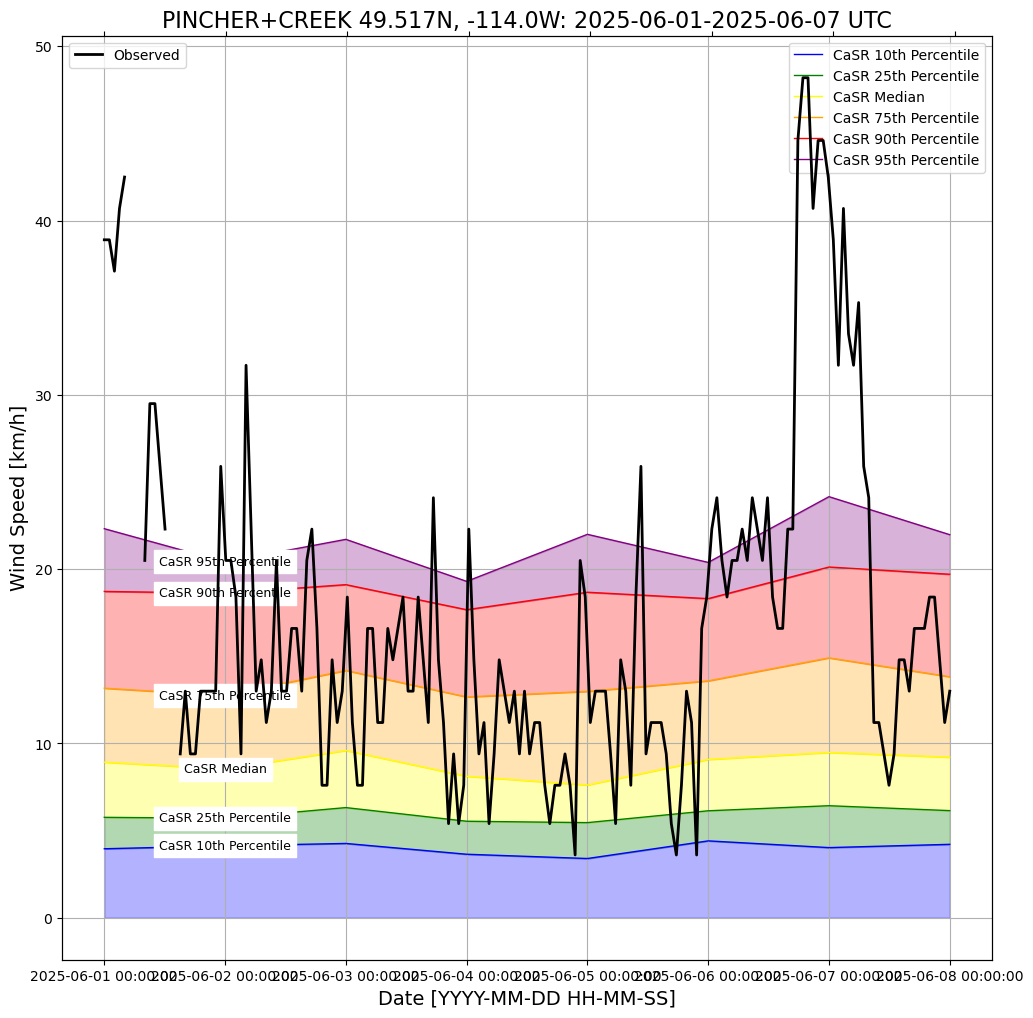

In [11]:
## Plot
plt.close()
from matplotlib.ticker import MultipleLocator
from plot_funcs import label_line
import matplotlib.dates as mdates
# plot all of the daily percentiles with nice colors
# then overlay the measurement with a thick black line if present!
fil_cols = ['Blue', 'Green', 'Yellow', 'Orange', 'Red', 'Purple']
name_cols = ["10th Percentile", "25th Percentile", "Median", "75th Percentile", "90th Percentile", "95th Percentile"]

fig, ax1 = plt.subplots(figsize=(12,12))

plt.xlabel("Date [YYYY-MM-DD HH-MM-SS]", fontsize=14)
plt.ylabel("Wind Speed [km/h]", fontsize=14)
plt.grid(True)
count = 0
for col in spd_interp_df.columns[1:]:  # first column is the dates
    y1 = spd_interp_df[col]
    line, = ax1.plot(np.arange(0, len(y1)), y1, label=f"CaSR {name_cols[count]}", color=fil_cols[count], linewidth=1)  
    label_line(ax1, line, x=1, fontsize=9, align=False, color='black')
    if count == 0:
        ax1.fill_between(x_aligned, 0, y1, alpha=0.3, color=fil_cols[count])  # spd_interp_df["date"]
    else: 
        ax1.fill_between(x_aligned, y0, y1, alpha=0.3, color=fil_cols[count])  # spd_interp_df["date"]
    count += 1
    y0 = y1

ax1.legend(loc='upper right')
if obs is not None:
    ax2 = ax1.twiny()
    ax2.plot(obs["rep_date"], obs["ws"], color="black", linewidth="2", label="Observed")
    ax2.legend(loc='upper left')
    # Set major ticks every 12 units
    ax2.xaxis.set_major_locator(MultipleLocator(24))
    # hide the axis labels on ax2 to avoid clutter
    ax2.axes.xaxis.set_ticklabels([])

plt.title(f"{selected_station} {selected_lat}N, {selected_lon}W: {start_date_str}-{end_date_str} UTC", fontsize=16)    
print(x_aligned, obs['rep_date'])
plt.show()